<a href="https://colab.research.google.com/github/dkovah/testing_stable_diffusion/blob/main/testing_stable_diffusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install diffusers==0.3.0
!pip install transformers scipy ftfy
!pip install "ipywidgets>=7,<8"
from google.colab import output
output.enable_custom_widget_manager()

In [2]:
from huggingface_hub import notebook_login

notebook_login()

Login successful
Your token has been saved to /root/.huggingface/token
Authenticated through git-credential store but this isn't the helper defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub. Run the following command in your terminal in case you want to set this credential helper as the default

git config --global credential.helper store


In [3]:
import torch
from torch import autocast
from PIL import Image
from diffusers import StableDiffusionPipeline
pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4", revision="fp16", torch_dtype=torch.float16, use_auth_token=True)
pipe = pipe.to("cuda")

Downloading:   0%|          | 0.00/1.34k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/12.5k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/342 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/543 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.63k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/608M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/209 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/209 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/572 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/246M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/525k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/472 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/788 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/772 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.72G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/71.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/550 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/167M [00:00<?, ?B/s]

{'trained_betas'} was not found in config. Values will be initialized to default values.


In [32]:
def dummy_checker(images, **kwargs): return images, False
pipe.safety_checker = dummy_checker
from random import randint

52718749


  0%|          | 0/21 [00:00<?, ?it/s]

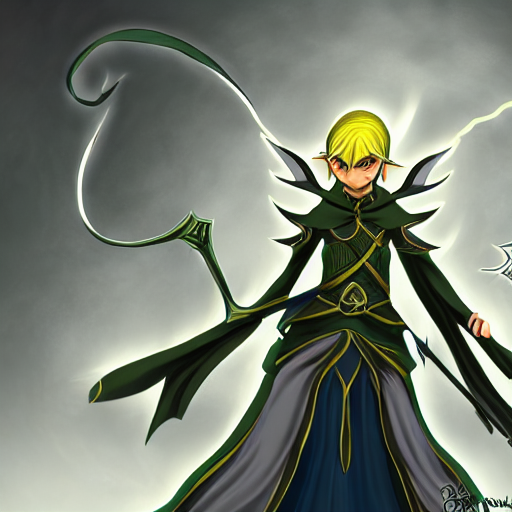

In [33]:
prompt = "Concept arc of an elf holding a blade"

seed = randint(0, 100000000)
print(seed)
generator = torch.Generator("cuda").manual_seed(seed)

with autocast("cuda"):
  image = pipe(prompt, num_inference_steps=20, generator=generator, height=512, width=512, guidance_scale=10).images[0]
image

In [ ]:
from diffusers import StableDiffusionImg2ImgPipeline
from google.colab import files
from io import BytesIO
# Display images.
from IPython.display import display
from PIL import Image, ImageEnhance

device = "cuda"
model_path = "CompVis/stable-diffusion-v1-4"

pipe_img = StableDiffusionImg2ImgPipeline.from_pretrained(
    model_path,
    revision="fp16", 
    torch_dtype=torch.float16,
    use_auth_token=True
)
pipe_img = pipe_img.to(device)

{'trained_betas'} was not found in config. Values will be initialized to default values.


In [ ]:
uploaded = files.upload()

Saving cuso.png to cuso (1).png


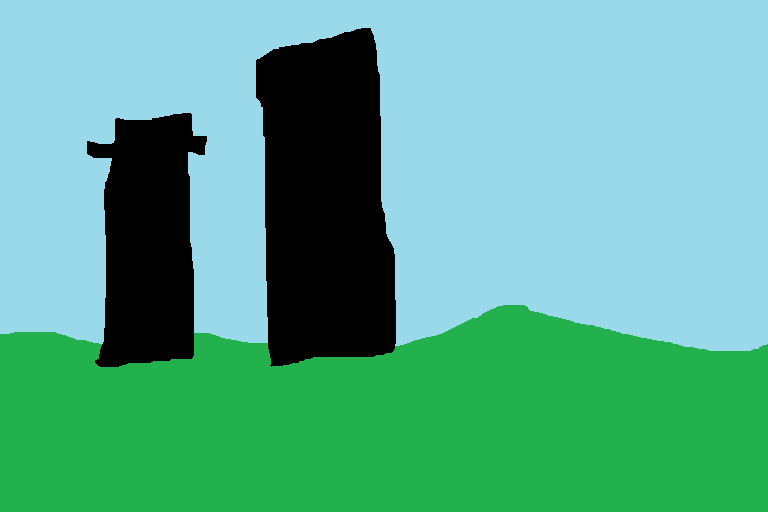

In [ ]:
image_name = 'cuso.png'
size = (768, 512)

image = Image.open(BytesIO(uploaded[image_name])).resize(size)
display(image)

  0%|          | 0/38 [00:00<?, ?it/s]

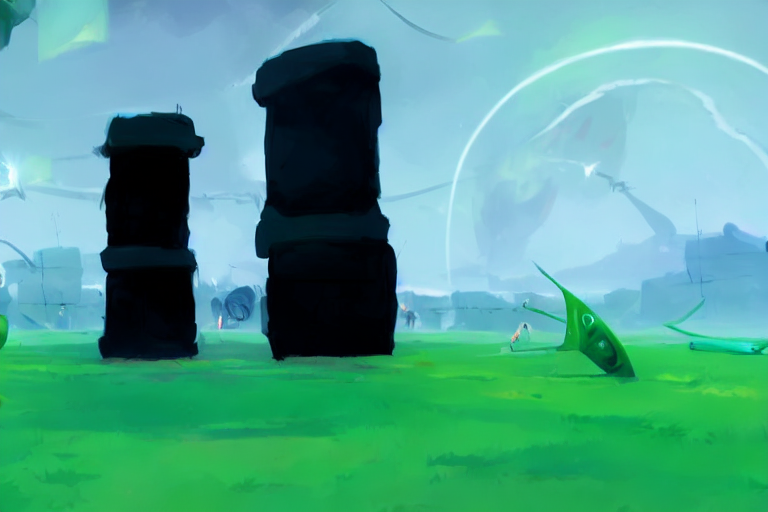

In [ ]:
prompt = "a battle arena, Marc Brunet digital artstyle"
generator2 = torch.Generator(device=device).manual_seed(234)

with autocast("cuda"):
    image = pipe_img(prompt=prompt, num_inference_steps=50, init_image=image, strength=0.75, guidance_scale=7.5, generator=generator2).images[0]
image